### Notebook for plotting the figures for GFD observed flooding

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import rasterio
import geopandas as gpd
import pycountry
import numpy as np
import yaml
import os
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import matplotlib as mpl
from adjustText import adjust_text

##### Define functions

In [11]:
# Define function combining geopackages
def combine_national_observed_decomposed_metrics(country_list):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", "countries", f"{country}",
                                       "inequality_metrics", f"{country}_ADM0_decomposed_metrics_gfd-flood_S-rwi.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")
    
    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")

def combine_national_observed_metrics(country_list):
    '''
    Function for combining national metrics into one geodataframe.
    Function takes as input:
        - the list of countries to combine (ISO3 codes)
    '''
    # List to store individual GeoDataFrames
    gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            metric_path = os.path.join("..", "data", "results", "social_flood", "countries", f"{country}",
                                       "inequality_metrics", f"{country}_ADM0_metrics_gfd-flood_S-rwi.gpkg")
            # Read the GeoPackage
            gdf = gpd.read_file(metric_path)
            # Append to list
            gdfs.append(gdf)
        except Exception as e:
            print(f"Error processing {country}: {e}")
    
    # Combine all GeoDataFrames
    if gdfs:
        combined_gdf = pd.concat(gdfs, ignore_index=True)
        return combined_gdf
    else:
        print("No valid data found")

def name_to_iso3(name):
    try:
        # lookup is case-insensitive and handles many common variants
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None      # or fallback string

##### Load Data

In [12]:
# Load countries from config file
with open(os.path.join("..", "config", "config.yaml"), "r") as file:
    config = yaml.safe_load(file)
countries = config.get("iso_codes", [])

In [13]:
# Combine observed data and clean dataframe
rwi_filter = 90 # want to filter out countries that have less than X% rwi coverage (default=90)
combined_metrics = combine_national_observed_metrics(countries)
combined_decomposed_metrics = combine_national_observed_decomposed_metrics(countries)
# Filter countries 
# based on the RWI population coverage
coverage_threshold = rwi_filter
combined_metrics = combined_metrics[combined_metrics['Population Coverage (%)'] > coverage_threshold]
combined_decomposed_metrics = combined_decomposed_metrics[combined_decomposed_metrics['Population Coverage (%)'] > coverage_threshold]
# remove 0 flood risk countries
combined_metrics = combined_metrics[combined_metrics['Total Flood Risk'] > 0]
combined_decomposed_metrics = combined_decomposed_metrics[combined_decomposed_metrics['Total Flood Risk'] > 0]
# Remove NaN CI rows (not valid RWI)
combined_metrics = combined_metrics[combined_metrics['CI'].notna()]
combined_decomposed_metrics = combined_decomposed_metrics[combined_decomposed_metrics['CI'].notna()]
# Add a percentage exposure column
combined_metrics['Perc_Exposure'] = (combined_metrics['Total Flood Risk'] / combined_metrics['Population'])*100
combined_decomposed_metrics['Perc_Exposure'] = (combined_decomposed_metrics['Total Flood Risk'] / combined_decomposed_metrics['Population'])*100
# Add a column of ISO3 codes (for printing)
combined_metrics['ISO3'] = combined_metrics['shapeName'].map(name_to_iso3)
combined_decomposed_metrics['ISO3'] = combined_decomposed_metrics['shapeName'].map(name_to_iso3)
# Add trouble columns manually
manual_codes = {
    'Bosnia & Herzegovina': 'BIH',
    'Central African Rep':    'CAF',
    "Cote d'Ivoire":          'CIV',
    'Congo, Dem Rep of the':  'COD',
    'Congo, Rep of the':      'COG',
    'Gambia, The':            'GMB',
    'Macedonia':              'MKD',
    'Swaziland':              'SWZ',
    'Turkey':                 'TUR'
}
combined_metrics['ISO3'] = combined_metrics['ISO3'].fillna(combined_metrics['shapeName'].map(manual_codes))
combined_decomposed_metrics['ISO3'] = combined_decomposed_metrics['ISO3'].fillna(combined_decomposed_metrics['shapeName'].map(manual_codes))

In [14]:
combined_metrics['Total Flood Risk'].sum()

np.float64(557063947.3277075)

In [15]:
# Create dataframe of uncertain country metrics
exposure_threshold = 50000 # cumulative flood exposure needs to be smaller than X ... AND
perc_threshold = 2 # smaller than x% of national population
uncertain_metrics =  combined_metrics[
    (combined_metrics['Total Flood Risk'] < exposure_threshold) &
    (combined_metrics['Perc_Exposure'] < perc_threshold)
]
uncertain_decomposed_metrics =  combined_decomposed_metrics[
    (combined_decomposed_metrics['Total Flood Risk'] < exposure_threshold) &
    (combined_decomposed_metrics['Perc_Exposure'] < perc_threshold)
]


In [16]:
uncertain_metrics['shapeName'].to_csv(f'uncertain_countries_et-{exposure_threshold}_pt-{perc_threshold}.csv')

PermissionError: [Errno 13] Permission denied: 'uncertain_countries_et-50000_pt-2.csv'

### Figures

##### Global CI Map

In [ ]:
# Plot a map of the observed CI metrics
# Map parameters
figsize = (15, 10)
colormap = plt.cm.bwr.reversed()
colormap_min = -1
colormap_max = 1
metric = "CI"
label = "Concentration Index"
hatch_pattern       = "////////////"
mpl.rcParams['hatch.linewidth'] = 0.4
mpl.rcParams['hatch.color'] = 'black'
base_crs = "EPSG:4326"
proj_crs = "EPSG:4326"

# Create a copy of original dataframe for mapping
map_df = combined_metrics.copy()
uncertain_df = uncertain_metrics.copy()
# Reproject
if map_df.crs is None:
    map_df = map_df.set_crs(base_crs)
map_df = map_df.to_crs(proj_crs)
if uncertain_df.crs is None:
    uncertain_df = uncertain_df.set_crs(base_crs)
uncertain_df = uncertain_df.to_crs(proj_crs)
# Simplify the admin boundaries (useful for plotting)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)
uncertain_df['geometry'] = uncertain_df['geometry'].simplify(tolerance=0.1)

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url)
    world = world.to_crs(proj_crs) # reproject
    world.plot(ax=ax, color='lightgray')
    
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Plot data for available countries
if metric in map_df.columns:
    # Create a mask for rows with non-null metric values
    valid_data = ~map_df[metric].isna()

    # Colormap normalizatoin
    norm = Normalize(vmin=colormap_min, vmax=colormap_max)

    # Plot coutnries with data using metric to control color
    map_df[valid_data].plot(column=metric,
                            ax=ax,
                            cmap=colormap,
                            norm=norm,
                            edgecolor='gray',
                            linewidth=0.2,
                            alpha=0.9)

    # Hash out uncertain countries
    uncertain_df[valid_data].plot(facecolor="none",
                       edgecolor='grey',
                       linewidth=0.2,
                       hatch=hatch_pattern,
                       ax=ax,
                       alpha=0.9)

    sm = ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    
    # Create the colorbar with custom positioning
    cax = fig.add_axes([0.162, 0.2, 0.7, 0.03])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    # Create evenly spaced ticks (5 ticks including min and max)
    tick_values = np.linspace(colormap_min, colormap_max, 5)
    cbar.set_ticks(tick_values)
    # Format the tick labels to have fewer decimal places
    cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])
    cbar.set_label(label)

# Turn off the axis
ax.set_axis_off()

# plt.show()
plt.savefig(fr"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\Howden\Write-Up\Paper\Figures\1_observed\observed_national_metrics_fe-{exposure_threshold}_fp-{perc_threshold}.png", dpi=300)

##### Country CI and contribution (stacked bar)

In [ ]:
# Prepare data
# Going to make a dataframe with valid data
valid_CI = combined_decomposed_metrics[
    (combined_decomposed_metrics['Total Flood Risk'] > exposure_threshold) |
    (combined_decomposed_metrics['Perc_Exposure'] > perc_threshold)
]
valid_CI = valid_CI.copy() # avoids Python warning
# Calculate rural, suburban,  and urban contributions
groups = {
    'rural': ['DUC11 Contribution', 'DUC12 Contribution', 'DUC13 Contribution'],
    'suburban' :['DUC21 Contribution', 'DUC22 Contribution', 'DUC23 Contribution'],
    'urban': ['DUC30 Contribution']
}
for newcol, cols in groups.items():
    valid_CI[newcol] = valid_CI[cols].sum(axis=1)
# Columns to keep
cols_keep = ['shapeName', 'ISO3', 'Total Flood Risk', 'CI', 'rural', 'suburban', 'urban']
valid_CI = valid_CI[cols_keep]

In [ ]:
# Plot the figure
rural_color = 'green'
suburban_color = 'yellow'
urban_color = 'red'
bar_transparency = 0.2
plt_cont = valid_CI.copy() # make copy of dataframe
plt_cont = plt_cont.sort_values('CI').reset_index(drop=True) # sort by CI
x = np.arange(len(plt_cont)) # x positions
classes = ['rural', 'suburban', 'urban'] # what are the urban classes
colors = {'rural': rural_color, 'suburban': suburban_color, 'urban': urban_color}
labels = {'rural': 'Rural Contribution', 'suburban': 'Suburban Contribution', 'urban': 'Urban Contribution'}

fig, ax = plt.subplots(figsize=(17, 4))

# Draw all negative contributions, stacking downward
bottom_neg = np.zeros_like(x, dtype=float)
for u_class in classes:
    neg_vals = plt_cont[u_class].clip(upper=0)
    ax.bar(x, neg_vals,
          bottom=bottom_neg,
          color=colors[u_class],
          alpha=bar_transparency)
    bottom_neg += neg_vals

# Draw all postive contributions, stacking upward
bottom_pos = np.zeros_like(x, dtype=float)
for u_class in classes:
    pos_vals = plt_cont[u_class].clip(lower=0)
    ax.bar(x, pos_vals,
          bottom=bottom_pos,
          color=colors[u_class],
          alpha=bar_transparency,
          label=labels[u_class].capitalize())
    bottom_pos += pos_vals

# Overlay the overall CI as a black "x"
ax.scatter(x, plt_cont['CI'],
          color='black',
          marker='x',
          s=50,
          label='Concentration Index')

# # Plot total Flood Exposure as blue circles (on twinned axis)
# ax2 = ax.twinx()

# # Plot flood exposure
# ax2.scatter(x, plt_cont['Total Flood Risk'],
#            color='blue', marker='o',
#            s=50, 
#            label='Flood Exposure')

# ax2.set_yscale('log')

# ax2.set_ylabel('Total flood exposure', color='blue')
# ax2.tick_params(axis='y', colors='blue')
# ax2.yaxis.set_label_position('right')
# ax2.yaxis.tick_right()


# Zero reference line
ax.axhline(0, color='gray', linewidth=0.8)
ax.xaxis.set_visible(False)
# Labels & legends
ax.set_xticks(x)
ax.set_xticklabels([])
ax.set_xticklabels([''] * len(x))
# Move country names to the zero line
# break-point country (for moving labels from above to below y=0 axis)
break_idx = plt_cont.index[plt_cont['ISO3'] == 'ECU'][0]
# make  y in axis-fraction coordinates
trans = ax.get_xaxis_transform()
for i, name in enumerate(plt_cont['ISO3']):
    if i <= break_idx:
        y = 0.6
    else:
        y = 0.49
    ax.text(i,                          # x‐position
            y,                          # y‐position at the zero line
            name,                       # the label
            rotation=90, 
            ha='center', 
            va='center',                # or 'center' if you prefer
            fontsize=10,
            transform=trans)
ax.set_xticklabels(plt_cont['shapeName'], rotation=90, fontsize=6)
ax.set_xlabel('Country')
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.margins(x=0.01)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
ax.set_ylabel('Concentration Index', fontsize=10)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout
plt.show()

#### Large events histogram

In [17]:
# Load data
directory_path = os.path.join("..", "data", "results", "social_flood", "events")
directory_names = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]

In [18]:
# Combine into one dataframe
results = []
invalid = []
valid = []
for i in directory_names:
    event_id = i.split("_")[1] # pull DFO ID
    df = pd.read_csv(os.path.join(directory_path, i, f"DFO_{event_id}_results.csv"))
    if df.empty:
        invalid.append(event_id)
        continue
    valid.append(event_id)
    for index, row in df.iterrows():
        new_row = {
            "DFO_ID": event_id,
            "ISO3": row['ISO3'],
            "FE": row['FE'],
            "BQFE": row['BQFE'],
            "CI": row['CI'],
            "QR": row['QR'],
            "Q1": row['Q1_exp'],
            "Q2": row['Q2_exp'],
            "Q3": row['Q3_exp'],
            "Q4": row['Q4_exp'],
            "Q5": row['Q5_exp'],
            "DUC11_CI": row['DUC11 CI'],
            "DUC12_CI": row['DUC12 CI'],
            "DUC13_CI": row['DUC13 CI'],
            "DUC21_CI": row['DUC21 CI'],
            "DUC22_CI": row['DUC22 CI'],
            "DUC23_CI": row['DUC23 CI'],
            "DUC30_CI": row['DUC30 CI'],
            "DUC11_S": row['DUC11 Risk Share'],
            "DUC12_S": row['DUC12 Risk Share'],
            "DUC13_S": row['DUC13 Risk Share'],
            "DUC21_S": row['DUC21 Risk Share'],
            "DUC22_S": row['DUC22 Risk Share'],
            "DUC23_S": row['DUC23 Risk Share'],
            "DUC30_S": row['DUC30 Risk Share'],
        }
        results.append(new_row)

results_df = pd.DataFrame(results, columns=["DFO_ID", "ISO3", "FE", "BQFE", "CI", "QR", "Q1", "Q2", "Q3", "Q4", "Q5", \
                                           "DUC11_CI", "DUC12_CI", "DUC13_CI", "DUC21_CI", "DUC22_CI", "DUC23_CI", "DUC30_CI", \
                                           "DUC11_S", "DUC12_S", "DUC13_S", "DUC21_S", "DUC22_S", "DUC23_S", "DUC30_S"])

In [19]:
len(results_df)

1777

In [23]:
# Filter to remove no flood events
results_df = results_df[results_df['FE'] > 0]
results_df['FE'].sum()

np.float64(530858713.9277118)

In [22]:
results_df

,DFO_ID,ISO3,FE,BQFE,CI,QR,Q1,Q2,Q3,Q4,...,DUC22_CI,DUC23_CI,DUC30_CI,DUC11_S,DUC12_S,DUC13_S,DUC21_S,DUC22_S,DUC23_S,DUC30_S
0,1595,UKR,89.939139,34.665460,-0.501182,0.000000,34.665460,55.273679,0.000000,0.000000,...,NaN,NaN,NaN,0.088942,0.296490,0.614364,0.000204,0.000000,0.000000,0.000000
1,1595,ROU,162.663195,25.764921,-0.328019,0.393790,25.764921,102.567822,0.774665,23.409621,...,NaN,0.224622,0.906396,0.017079,0.154920,0.751279,0.073780,0.000000,0.002871,0.000071
2,1595,BGR,154.493473,1.856442,-0.436020,0.000000,1.856442,152.637032,0.000000,0.000000,...,NaN,NaN,NaN,0.003570,0.000000,0.000000,0.996430,0.000000,0.000000,0.000000
3,1595,SRB,1.507271,0.000000,-0.418107,NaN,0.000000,1.507095,0.000175,0.000000,...,NaN,NaN,NaN,0.999884,0.000116,0.000000,0.000000,0.000000,0.000000,0.000000
5,1614,VNM,214484.554076,90704.563955,-0.351936,0.254186,90704.563955,52949.046467,32751.017438,15024.061851,...,-0.288136,0.038775,0.383997,0.019346,0.225959,0.030879,0.408607,0.058411,0.071606,0.185191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,4703,BRA,155.928443,120.808663,-0.722443,0.000000,120.808663,26.856798,4.138897,4.124085,...,NaN,NaN,-0.061344,0.300740,0.549609,0.000000,0.115808,0.000000,0.000000,0.033842
1773,4703,BOL,45.888372,45.888372,-0.685465,0.000000,45.888372,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.177517,0.822483,0.000000,0.000000,0.000000,0.000000,0.000000
1774,4703,PRY,2550.029505,523.358640,-0.237782,0.115880,523.358640,1139.199104,298.095219,528.729003,...,0.320788,-0.069484,0.060310,0.150345,0.372284,0.018468,0.150005,0.022413,0.027539,0.258946
1775,4703,ARG,3262.584008,623.173279,0.176364,2.611762,623.173279,404.487259,369.937183,237.403928,...,NaN,-0.306751,0.489034,0.027944,0.093359,0.091345,0.024540,0.000000,0.087648,0.675165


In [29]:
# Only look at large flood events (exposure > 100,000)
threshold = 5000
filtered_df = results_df[results_df['FE'] >= threshold]
filtered_df.to_csv(f"DFO_results_v2_exposure-gt-{threshold}.csv")

In [30]:
len(filtered_df)

769

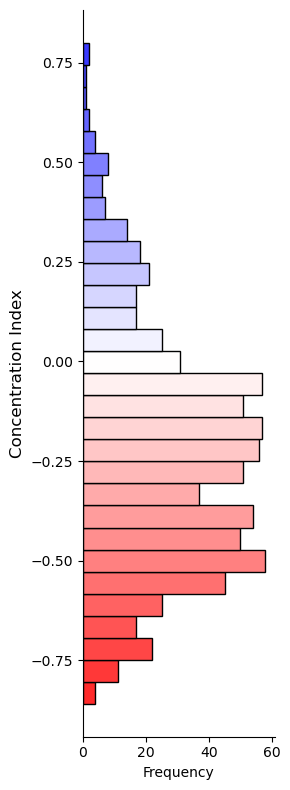

In [35]:
# Plot histogram
histogram_df = filtered_df.dropna(subset=['CI'])

# 1. Create a tall figure
fig, ax = plt.subplots(figsize=(3, 8))   # taller than it is wide

# 2. Plot a horizontal histogram
counts, bins, patches = ax.hist(
    histogram_df['CI'],
    bins=30,
    edgecolor='k',
    orientation='horizontal'
)

# 3. Color by bin‐center
norm = Normalize(vmin=-1, vmax=1)
cmap = plt.cm.bwr.reversed()
for left, right, patch in zip(bins[:-1], bins[1:], patches):
    center = (left + right) / 2
    patch.set_facecolor(cmap(norm(center)))

# 4. Labels & limits
# ax.set_ylim(-1, 1)
ax.set_ylabel('Concentration Index', fontsize=12)
ax.set_xlabel('Frequency')
# ax.set_title('Vertical (horizontal-bar) Histogram of CI for Flood Events >100K exposure')

# ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

In [39]:
histogram_df['CI'].std()

np.float64(0.3045223782257179)

#### Event Concentration Curves

In [17]:
# User Inputs
ISO3 = 'IND'
event_id = '4179'

In [31]:
# File paths
pop_path = os.path.join('..', 'data', 'inputs', 'analysis', 'countries', f'{ISO3}', f'{ISO3}_ghs-pop.tif')
rwi_path = os.path.join('..', 'data', 'inputs', 'analysis', 'countries', f'{ISO3}', f'{ISO3}_rwi.tif')
mask_path = os.path.join('..', 'data', 'inputs', 'analysis', 'countries', f'{ISO3}', f'{ISO3}_surface_water.tif')
flood_path = os.path.join('..', 'data', 'inputs', 'analysis', 'events', f'DFO_{event_id}',f'{ISO3}_{event_id}.tif')

In [33]:
# Load raster data
with rasterio.open(rwi_path) as rwi_src, rasterio.open(pop_path) as pop_src, rasterio.open(flood_path) as flood_src, \
    rasterio.open(mask_path) as mask_src:
    rwi = rwi_src.read(1)
    pop = pop_src.read(1)
    mask = mask_src.read(1)
    flood = flood_src.read(1)
    affine = pop_src.transform
rwi[rwi==-999] = np.nan # convert -999 in RWI dataset to NaN
water_mask = np.where(mask>50, np.nan, 1) # WARNING WE ARE HARD CODING PERM_WATER > 50% mask here

MemoryError: Unable to allocate 1.13 GiB for an array with shape (1, 34511, 35081) and data type uint8

In [34]:
# Prepare data
# Mask areas 
mask_areas = (
    ~np.isnan(pop) &
    ~np.isnan(rwi) &
    ~np.isnan(flood) &
    ~np.isnan(water_mask)
    )
# Flatten data
pop_flat = pop[mask_areas]
rwi_flat = rwi[mask_areas]
flood_flat = flood[mask_areas]
# Mask out zero-populatoin cells
valid = pop_flat > 0
pop_flat = pop_flat[valid]
rwi_flat = rwi_flat[valid]
flood_flat = flood_flat[valid]

NameError: name 'flood' is not defined

In [ ]:
# Create analysis dataframe
df = pd.DataFrame({
    'pop': pop_flat,
    'rwi': rwi_flat,
    'flood': flood_flat,
})

In [ ]:
# Function for extracting concentration curve data
def compute_concentration_curve(data):
    # Sort by RWI ascending
    data = data.sort_values(by="rwi", ascending=True).copy()
    data['cum_pop'] = data['pop'].cumsum()
    data['flood_pop'] = data['flood'] * data['pop']  # flood burden
    data['cum_flood_pop'] = data['flood_pop'].cumsum()
    total_pop = data['pop'].sum()
    total_flood_pop = data['flood_pop'].sum()
    data['frac_pop'] = data['cum_pop'] / total_pop
    data['frac_flood'] = data['cum_flood_pop'] / total_flood_pop
    # Insert 0 at the beginning for a proper starting point at (0,0)
    x_vals = np.insert(data['frac_pop'].values, 0, 0)
    y_vals = np.insert(data['frac_flood'].values, 0, 0)
    return x_vals, y_vals

x, y = compute_concentration_curve(df)

In [ ]:
# Plot the concentration curve
plt.figure(figsize=(6, 5))
plt.plot(x, y, label=f'DFO {event_id}', color='dodgerblue')
# plt.title('Observed Concentration Curve - Bhutan')
plt.plot([0,1], [0,1], "--", color='gray', label='Equality Line')
plt.xlabel('Cumulative Population (Wealth Rank)')
plt.ylabel('Cumulative Flood Risk Exposure')
plt.legend()